<a href="https://colab.research.google.com/github/MandyB0716/MyPortfolio/blob/main/GHWcloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torchsummary

from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler

In [7]:
class DeepNN(nn.Module):
  def __init__(self):
    super(DeepNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.fc1 = nn.Linear(in_features=64*7*7, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=10)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = x.view(x.size(0), -1)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    return x


In [3]:
def visualize_model():
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = DeepNN().to(device)
  torchsummary.summary(model, (1, 28, 28))

In [8]:
visualize_model()


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.65
Params size (MB): 1.61
Estimated Total Size (MB): 2.26
-------------------------------------------

In [9]:
def get_data_loader(batch_size=32, train=True):
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,))
  ])
  dataset = datasets.MNIST(root='./data', train=train, download=True, transform=transform)
  data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=4, pin_memory=True)
  return data_loader


In [13]:
def train_model(epochs=5):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = DeepNN().to(device)
  train_loader = get_data_loader()
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  scaler = GradScaler()

  for e in range(epochs):
    for images, labels in train_loader:
      images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
      optimizer.zero_grad()
      with autocast(device_type='cuda'):
        outputs = model(images)
        loss = criterion(outputs, labels)
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
    print(f'Epoch: {e+1}/{epochs}, Loss: {loss.item()}')
  torch.save(model.state_dict(), 'model.pth')
  print('Model saved')

In [14]:
train_model(10)

Epoch: 1/10, Loss: 0.004238631576299667
Epoch: 2/10, Loss: 0.0008899420499801636
Epoch: 3/10, Loss: 0.0008748918771743774
Epoch: 4/10, Loss: 0.00038993731141090393
Epoch: 5/10, Loss: 7.098540663719177e-05
Epoch: 6/10, Loss: 2.617761492729187e-05
Epoch: 7/10, Loss: 1.8674880266189575e-05
Epoch: 8/10, Loss: 0.0002798140048980713
Epoch: 9/10, Loss: 4.458799958229065e-05
Epoch: 10/10, Loss: 5.193054676055908e-06
Model saved


In [18]:
def test_model():
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = DeepNN().to(device)
  model.load_state_dict(torch.load('model.pth', map_location=device))
  model.eval()

  test_loader = get_data_loader(train=False)
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print(f'Accuracy: {100*correct/total}%')

In [19]:
test_model()


<ipython-input-18-8e44d2deae9d>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth', map_location=device))
/usr/local/lib/python3.1

Accuracy: 99.12%


In [26]:
def visualize_predictions():
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = DeepNN().to(device)
  model.load_state_dict(torch.load('model.pth', map_location=device))
  model.eval()

  test_loader = get_data_loader(train=False)

  images, labels = next(iter(test_loader))
  images, labels = images.to(device), labels.to(device)
  outputs = model(images)
  _, predicted = torch.max(outputs.data, 1)
  images = images.cpu().numpy()
  fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(10, 10))
  for i, ax in enumerate(axes.flat):
    img = np.squeeze(images[i])
    ax.imshow(img, cmap='gray')
    ax.set_title(f'{predicted[i].item()}')
    ax.axis('off')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

<ipython-input-26-1dc0665989ba>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth', map_location=device))


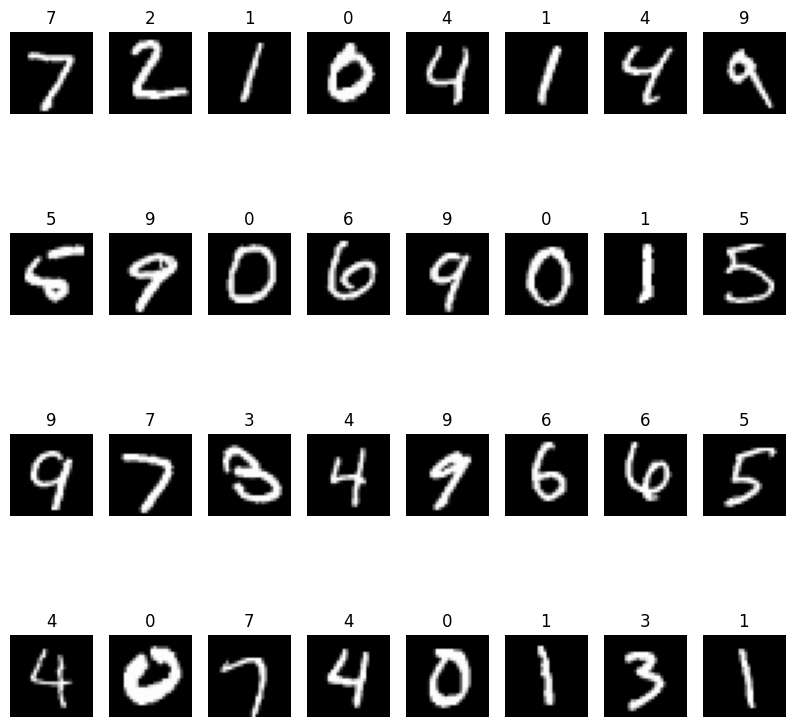

In [27]:
visualize_predictions()